In [3]:
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from transformers import AdamW
import math
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import re

In [22]:
df = pd.read_csv("data.csv")
df

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1
...,...,...
226829,Но не каждый хочет что то исправлять:( http://...,0
226830,скучаю так :-( только @taaannyaaa вправляет мо...,0
226831,"Вот и в школу, в говно это идти уже надо(",0
226832,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0


Удалим из всех текстов ссылки, которые не несут в себе никакую информацию для окраски настроения текста

In [38]:
def remove_links(text):
  link_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  cleaned_text = re.sub(link_pattern, '', text)
  return cleaned_text


In [39]:
df["text"] = [remove_links(text) for text in df["text"].tolist()]

In [40]:
texts = df["text"].tolist()
labels = df["label"].tolist()

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [70]:
class TransformerClassificationModel(nn.Module):
  def __init__(self, base_transformer_model: nn.Module, hidden_size: int, num_classes: int):
    super().__init__()
    self.backbone = base_transformer_model
    self.batch_norm = nn.BatchNorm1d(hidden_size)
    self.dropout = nn.Dropout()
    print(self.backbone.config.hidden_size)
    self.linear1 = nn.Linear(self.backbone.config.hidden_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, num_classes)
    self.activation = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, attention_mask):
    features = self.backbone(x, attention_mask=attention_mask)
    out = features.last_hidden_state[:, 0, :] #выбираем скрытое состояние только первого токена [CLS]
    out = self.activation(out)
    out = self.dropout(out)
    out = self.linear1(out)
    out = self.batch_norm(out)
    out = self.activation(out)
    out = self.linear2(out)
    out = self.sigmoid(out)
    return out

In [67]:
def freeze_backbone_function(model):
  for param in model.parameters():
    param.requires_grad = False
  return model

In [68]:
sigmoid = nn.Sigmoid()
def train_transformer(transformer_model, num_epochs, train_texts, train_labels, valid_texts, valid_labels, batch_size, freeze_backbone=True):

  if freeze_backbone:
    transformer_model = freeze_backbone_function(transformer_model)

  model = TransformerClassificationModel(transformer_model, 256, 1)
  criterion = nn.BCELoss()
  optimizer = AdamW(model.parameters(), lr=1e-5)
  model.to(device)

  for i in range(1, num_epochs + 1):
    epoch_loss_train = 0
    model.train()
    with tqdm(total=math.ceil(train_texts['input_ids'].size(0) / batch_size), desc=f'Epoch {epoch}', unit='batch') as pbar:
      for i in range(0, train_texts['input_ids'].size(0), batch_size):
        texts_batch = train_texts["input_ids"][i : i + batch_size].to(device)
        masks_batch = train_texts["attention_mask"][i : i + batch_size].to(device)
        label_batch = train_labels[i : i + batch_size].float().to(device)

        optimizer.zero_grad()
        preds = model(texts_batch, masks_batch)
        loss = criterion(preds.squeeze(), label_batch)
        loss.backward()
        optimizer.step()

        epoch_loss_train += loss.item()
        pbar.update(1)

    model.eval()
    with torch.no_grad():
      epoch_loss_valid = 0
      accuracy = 0
      count = 0
      for i in range(0, valid_texts['input_ids'].size(0), batch_size):
        texts_batch = valid_texts["input_ids"][i : i + batch_size].to(device)
        masks_batch = valid_texts["attention_mask"][i : i + batch_size].to(device)
        label_batch = valid_labels[i : i + batch_size].float().to(device)
        preds = model(texts_batch, masks_batch)
        loss = criterion(preds.squeeze(), label_batch)
        epoch_loss_valid += loss.item()
        threshold = 0.5
        binary_preds = (sigmoid(preds.squeeze()) > threshold).int().detach().cpu().numpy()
        accuracy += accuracy_score(label_batch.detach().cpu().numpy(), binary_preds)
        count += 1

    print(f"Epoch №{epoch}; Train Loss: {epoch_loss_train / math.ceil(train_texts['input_ids'].size(0) / batch_size):.4f}; Eval Loss: {epoch_loss_valid / count:.4f}; Accuracy: {accuracy / count:.3f}")

  finetuned_model = model
  return finetuned_model

Разделим текст на тренировочный, валидационный и текстовый

In [46]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels,
                                                                      test_size=0.15, random_state=42,
                                                                      shuffle=True, stratify=labels)
train_texts, validation_texts, train_labels, validation_labels = train_test_split(train_texts, train_labels,
                                                                      test_size=0.15, random_state=42,
                                                                      shuffle=True, stratify=train_labels)


*Рассказать про WordPiece tokenization

In [49]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
tokenized_train_texts = tokenizer(train_texts, return_tensors="pt", padding="max_length", max_length=40, truncation=True)
tokenized_validation_texts = tokenizer(validation_texts, return_tensors="pt", padding="max_length", max_length=40, truncation=True)
tokenized_test_texts = tokenizer(test_texts, return_tensors="pt", padding="max_length", max_length=40, truncation=True)

for key, values in tokenized_train_texts.items():
    values_type = type(values).__name__
    print(f"{key}: {values_type}, {values.shape}")

input_ids: Tensor, torch.Size([163886, 40])
token_type_ids: Tensor, torch.Size([163886, 40])
attention_mask: Tensor, torch.Size([163886, 40])


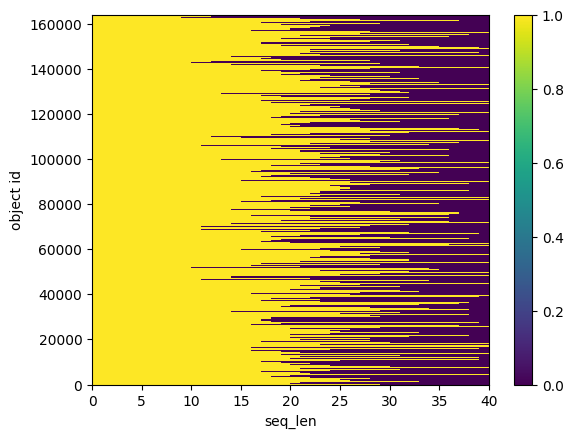

In [50]:
import matplotlib.pyplot as plt

plt.pcolormesh(tokenized_train_texts["attention_mask"])
plt.xlabel("seq_len")
plt.ylabel("object id")
plt.colorbar()
plt.show()

In [62]:
decoded_train_text = tokenizer.convert_ids_to_tokens(tokenized_train_texts['input_ids'][3])


# Печать результатов
print("Тренировочный текст:", train_texts[3])
print("Токенизированный тренировочный текст:", decoded_train_text)

Тренировочный текст: @i_yakovleva Да она уже даже немножко надоесть успела, а ты все еще мылишься!))
Токенизированный тренировочный текст: ['[CLS]', '@', 'i', '_', 'ya', '##kov', '##lev', '##a', 'Да', 'она', 'уже', 'даже', 'немножко', 'надое', '##сть', 'успела', ',', 'а', 'ты', 'все', 'еще', 'мы', '##ли', '##шься', '!', ')', ')', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


*Рассказать про BERT и про rubert-tiny2

In [65]:
rubert_tiny_transformer_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
rubert_tiny_transformer_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(83828, 312, padding_idx=0)
    (position_embeddings): Embedding(2048, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
   

In [71]:
epoch = 1
rubert_tiny_finetuned = train_transformer(rubert_tiny_transformer_model, num_epochs=1,
                                                                train_texts=tokenized_train_texts, train_labels=torch.tensor(train_labels),
                                                                valid_texts=tokenized_validation_texts, valid_labels=torch.tensor(validation_labels),
                                                                batch_size=128, freeze_backbone=True)

TypeError: TransformerClassificationModel.__init__() missing 1 required positional argument: 'num_classes'